In [6]:
import sys
import os

# Add parent and grandparent directories to sys.path
sys.path.insert(0, '..')
sys.path.insert(0, '../..')

from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import h5py
import networkx as nx
import itertools
from itertools import combinations

from src import (
    setup,
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    ket
)
from Scripts import hdf5merge
from Scripts import simulation_CLI as cleo

In [2]:
def find_connected_pairs(adjacency_matrix):
    connected_pairs = []
    num_nodes = len(adjacency_matrix)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # Ensure we only consider distinct pairs
            if adjacency_matrix[i][j] == 1:  # If there's a connection between nodes i and j
                connected_pairs.append([i, j])  # Use a list [i, j] instead of a tuple (i, j)

    return connected_pairs

def find_two_node_subgroups(adjacency_matrix, num_pairs):
    connected_pairs = find_connected_pairs(adjacency_matrix)
    num_nodes = len(adjacency_matrix)

    all_subgroups = []

    def is_valid(curr_pair):
        nodes = [node for pair in curr_pair for node in pair]
        return len(set(nodes)) == num_nodes

    def backtrack(curr_pair, remaining_pairs):
        if len(curr_pair) == num_pairs:
            sorted_curr_pair = sorted(curr_pair)
            if is_valid(sorted_curr_pair):
                all_subgroups.append(sorted_curr_pair)
            return

        for pair in remaining_pairs:
            if all(node not in [n for p in curr_pair for n in p] for node in pair):
                curr_pair.append(pair)
                next_pairs = [p for p in remaining_pairs if p != pair]
                backtrack(curr_pair, next_pairs)
                curr_pair.pop()

    backtrack([], connected_pairs)

    # Remove duplicates
    unique_subgroups = {frozenset(map(tuple, subgroup)) for subgroup in all_subgroups}
    unique_subgroups = [list(map(list, subgroup)) for subgroup in unique_subgroups]

    # Convert the result to a list of np.array
    unique_subgroups_np = [np.array(subgroup) for subgroup in unique_subgroups]

    return unique_subgroups_np

# Function to plot the adjacency matrix
def plot_adjacency_matrix(adjacency_matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.colorbar()
    plt.show()

def plot_chosen_pairs(adjacency_matrix, chosen_pairs):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix with Chosen Pairs')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')

    # Plot chosen pairs
    for pair in chosen_pairs:
        plt.plot(pair, pair, color='red')  # Plot each pair

    plt.colorbar()
    plt.show()

def plot_network_graph(adjacency_matrix):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)

    G = nx.from_numpy_array(adj_matrix)
    pos = nx.circular_layout(G)

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, edge_color='gray', width=2)

    # Add edges based on the adjacency matrix
    #for i in range(num_nodes):
    #    for j in range(i+1, num_nodes):
    #        if adjacency_matrix[i][j] == 1:
    #            G.add_edge(i, j)

    plt.title('Network Graph')
    plt.show()

# Function to plot the network graph with highlighted pairs
def plot_network_graph_with_highlight(adjacency_matrix, chosen_pairs):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)

    # Add edges based on the adjacency matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Define positions for nodes
    # You can use a layout that suits your needs; here we use circular layout
    # which is good for small graphs.
    # You can also use other layouts like spring_layout, shell_layout, etc.
    # For larger graphs, consider using a layout that minimizes overlap.
    # For example, you can use nx.spring_layout(G) for a force-directed layout.
    # For a circular layout, use:
    # pos = nx.circular_layout(G)
    # For a spring layout, use:
    # pos = nx.spring_layout(G)
    # For a shell layout, use:
    # pos = nx.shell_layout(G)
    # Here we use the circular layout for simplicity.
    # You can change the layout as needed.
    # For larger graphs, consider using a layout that minimizes overlap.
    # For example, you can use nx.spring_layout(G) for a force-directed layout.
    # For a circular layout, use:
    # pos = nx.circular_layout(G)
    # For a spring layout, use:
    # pos = nx.spring_layout(G)
    # For a shell layout, use:
    # pos = nx.shell_layout(G)
    pos = nx.circular_layout(G)  # Positions for all nodes

    plt.figure(figsize=(8, 8))

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12)

    # Highlight chosen pairs
    for pair in chosen_pairs:
        nx.draw_networkx_edges(G, pos, edgelist=[pair], width=2, edge_color='orange')
        nx.draw_networkx_nodes(G, pos, nodelist=pair, node_color='lightblue', node_size=1000)

    plt.title('Network Graph with Highlighted Pairs')
    plt.show()

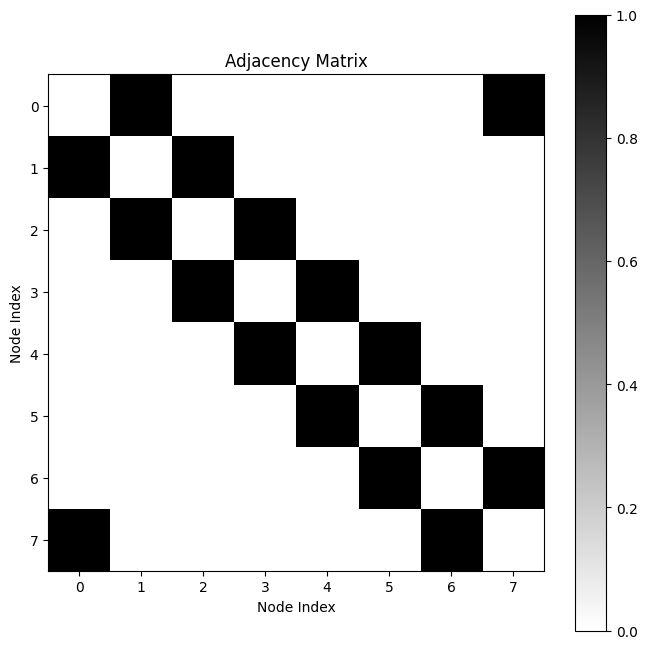

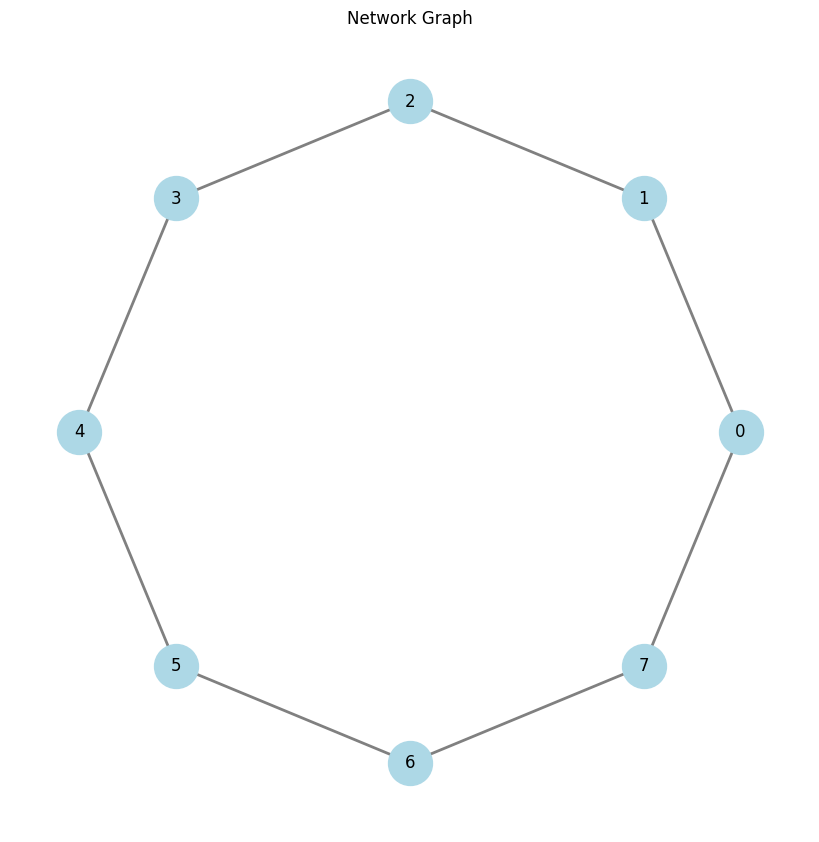

Unique subgroups of pairs as np.array:
[array([[0, 7],
       [1, 2],
       [3, 4],
       [5, 6]]), array([[0, 1],
       [6, 7],
       [4, 5],
       [2, 3]])]
2


In [4]:
adj_matrix = np.array([[0, 1, 0, 0, 0, 0, 0, 1],
     [1, 0, 1, 0, 0, 0, 0, 0],
     [0, 1, 0, 1, 0, 0, 0, 0],
     [0, 0, 1, 0, 1, 0, 0, 0],
     [0, 0, 0, 1, 0, 1, 0, 0],
     [0, 0, 0, 0, 1, 0, 1, 0],
     [0, 0, 0, 0, 0, 1, 0, 1],
     [1, 0, 0, 0, 0, 0, 1, 0]])

plot_adjacency_matrix(adj_matrix)
plot_network_graph(adj_matrix)

# Find all possible combinations of two-node connected subgroups
num_pairs = 4
subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("Unique subgroups of pairs as np.array:")
print(subgroups)
print(len(subgroups))

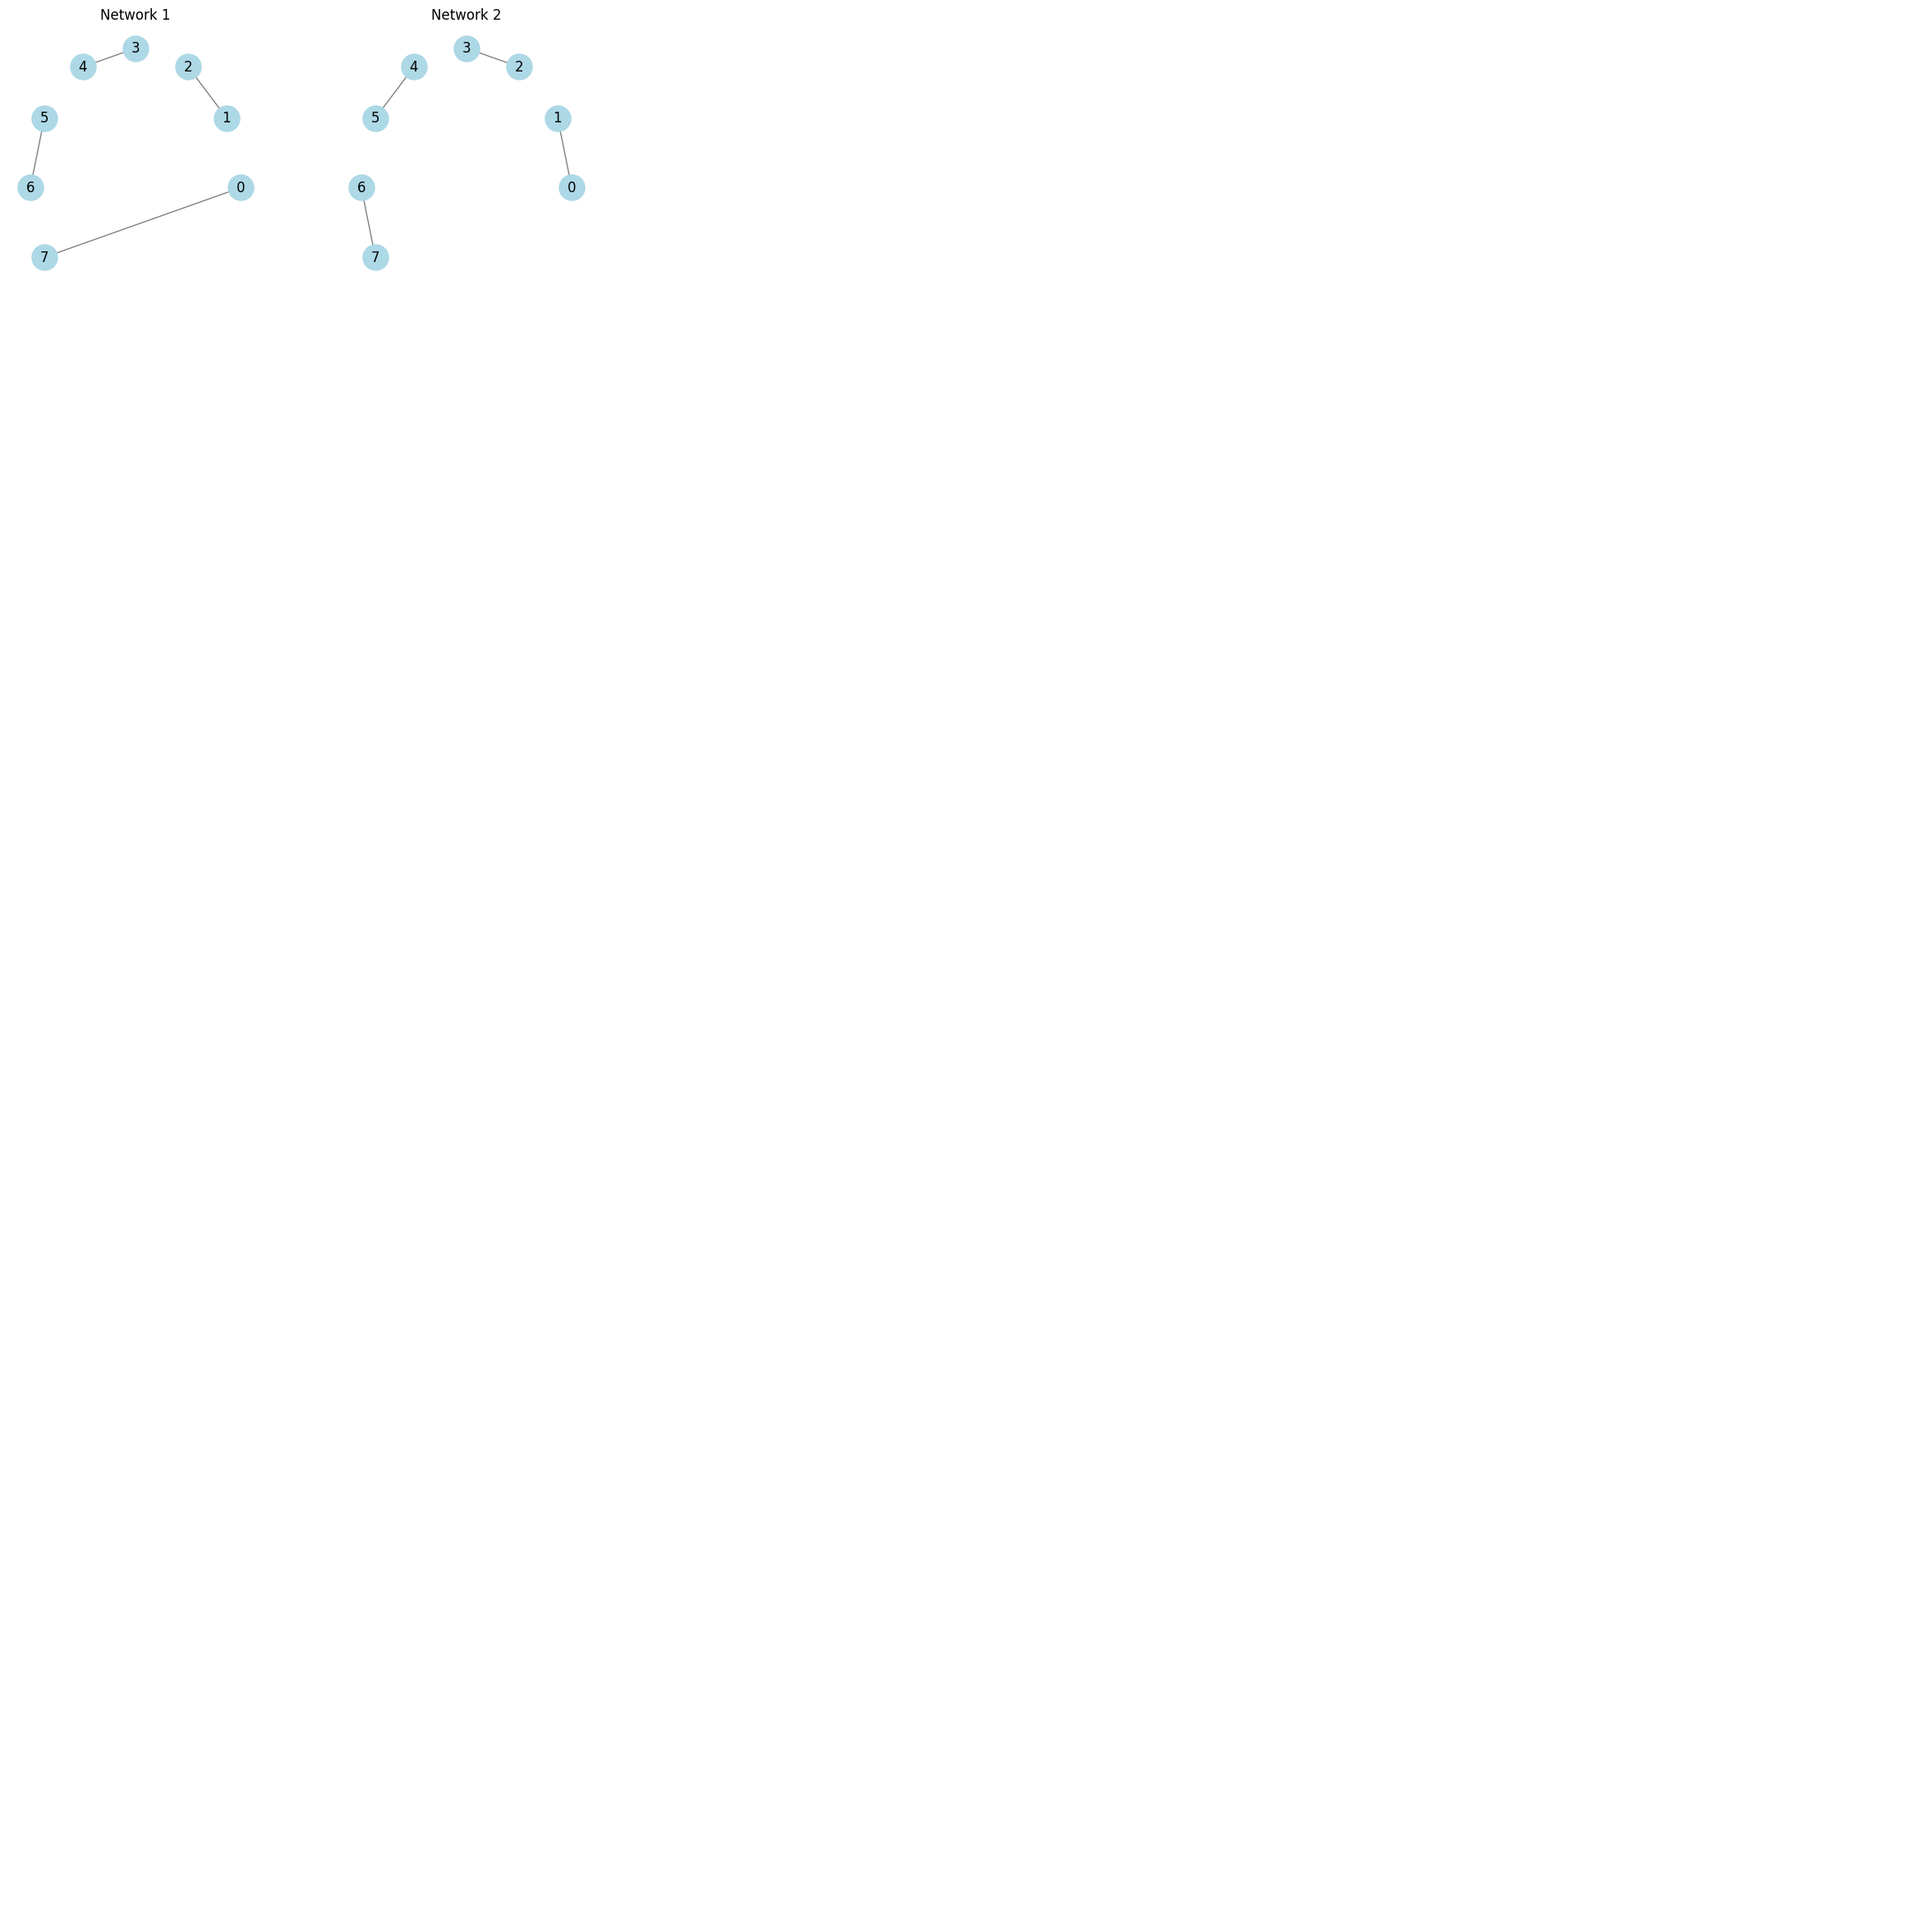

In [5]:
list_of_pairs = subgroups
#Make rows and columns of the subplots match the number of pairs. For the above adj matrix that 36 configurations, hence 6x6
#nxm=6x6
n=6
m=6
fig, axes = plt.subplots(n, m, figsize=(30, 30))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Function to visualize a graph from a list of pairs
def visualize_network(pairs, ax, title):
    G = nx.Graph()
    G.add_edges_from(pairs)
    node_order = list(range(12))

# Calculate positions for each node in a circle
    angle = 2 * np.pi / len(node_order)
    pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, edge_color='gray', ax=ax)
    ax.set_title(title, fontsize=12)

# Plot each network in the grid
for idx, ax in enumerate(axes.flat):
    if idx < len(list_of_pairs):
        visualize_network(list_of_pairs[idx], ax, f"Network {idx + 1}")
    else:
        ax.axis('off')

#uncomment the code below if you want to save image.
#dpi is "dots per inch" and just refers to resolution
#tight means the saved figure does not have any white space
#plt.savefig("Connectivities.png",dpi=300, bbox_inches="tight")
plt.show()

In [8]:
Trials = 10
num=8
for unitary_seed in range(Trials):
    #initial_pops = [0.043407, 0.12, 0.09, 0.15, 0.3,0.14, 0.23, 0.026593]
    initial_pops = [1, 0, 0, 0, 1, 0, 0, 1]
    #initial_pops = [0.1,0.1,0.1,0.1,0.4,0.1,0.1,0.1]
    system = DM.n_thermal_qbits(initial_pops)
    connectivity = "c2_2local"
    unitary_energy_subspace = 1
    ordering_seed = 1
    chunk_size = 2
    #random, mimic, greedy, landscape_maximizes, strongest_maximizes
    order_rule_name = "greedy"
    num_steps = 100
    data = cleo.execute(file_name="greedy",
                        connectivity=connectivity,
                        order_rule_name=order_rule_name,
                        unitary_seed=unitary_seed,
                        unitary_energy_subspace=unitary_energy_subspace,
                        evolution_generator_type="haar2Qunitary",
                        chunk_size=chunk_size,
                        num_steps=num_steps,
                        initial_pops=initial_pops,
                        verbosity=.9);

simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed

In [9]:
hdf5merge.merge_hdf5_files("../data/greedy")
newdata = dict(h5py.File("../data/greedy/greedy.hdf5"))

In [10]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

Removes the first 201 and last 250 time steps from a trial's data, then computes the mean over the remaining time steps for each qubit. Returns the average population per qubit at late times.

In [11]:
def late_time_average_of_list(list_one_trial):
    late_time_data=np.delete(list_one_trial,slice(0,201),1)
    late_time_data=np.delete(list_one_trial,slice(51,301),1)
    ensemble_average = np.mean(late_time_data, axis=0)  # Shape (100, N)
    return (ensemble_average)

For a set of datasets (already averaged over seeds), removes early and late time steps, averages over the late-time window, then averages over seeds. Returns the mean and standard deviation across qubits.

In [12]:
def late_time_averages_one_point_all_seeds_between_q(datasets):
    # Trim down the arrays to a segment of late time data
    # Assuming datasets is a list of time steps (axis 0) for each qubit (axis 1), already averaged over seeds

    late_time_data = np.delete(datasets, slice(0, 201), 1)
    late_time_data = np.delete(late_time_data, slice(51, 301), 1)

    # Take the average over the late time values
    late_time_ave = np.mean(late_time_data, axis=1)

    # Take the average over seeds
    late_time_seed_ave = np.mean(late_time_ave, axis=0)

    # Finally, define the mean for each qubit, and the std deviation of qubits
    qubit_mean = np.mean(late_time_seed_ave)
    stddev_over_qubits = np.std(late_time_seed_ave)
    return qubit_mean, stddev_over_qubits


Should compute the time average up to time t for a dataset by summing up to t and dividing by t+1.

In [13]:
def time_averaged_one_point_measures_at_t(dataset,t):
    # Assuming dataset is list of 100 lists i.e. one trial
    #stack datasets in 3D
    # Take the ensemble average along the first axis (averaging over all datasets)
    sum_till_t = np.sum(dataset[:t], axis=0)
    time_average_t = (1/(t+1))*(sum_till_t)
    return (time_average_t)

In [14]:
def moving_average(data, window_size):
    data = np.asarray(data)
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0")
    if data.shape[0] < window_size:
        raise ValueError("Number of time steps must be >= window size")
    # Apply moving average along each column
    return np.apply_along_axis(
        lambda m: np.convolve(m, np.ones(window_size)/window_size, mode='valid'),
        axis=0,
        arr=data
    )

Stacks multiple datasets (trials), computes the mean and standard deviation across trials for each time step and qubit.

In [15]:
#Returns ensembled average one point dataset ie data should look like a full seed
def ensemble_averaged_one_point_measures_mean_std(datasets):
    # Assuming datasets is a list of 100 datasets, where each dataset is a 2D array of shape (100, N)
    # Stack datasets into a 3D array
    stacked_data = np.stack(datasets)  # Shape (100, 100, N)

    # Take the ensemble average along the first axis (averaging over all datasets)
    ensemble_average = np.mean(stacked_data, axis=0)  # Shape (100, N)

    # Calculate the standard deviation along the first axis
    ensemble_std = np.std(stacked_data, axis=0)
    return (ensemble_average, ensemble_std)

Applies late_time_average_of_list to each trial, then computes the mean and standard deviation across all trials for each qubit.

In [16]:
def ensemble_average_late_time_mean_std_value(list_of_lists):
    late_time_per_trial=[]
    for l in list_of_lists:
        late_time_per_trial.append(late_time_average_of_list(l))
    mean_value = np.mean(late_time_per_trial,axis=0)
    std_value = np.std(late_time_per_trial,axis=0)
    return (mean_value,std_value)

For data already averaged over seeds, removes early and late time steps, averages over the late-time window, and returns the mean and standard deviation across qubits.

In [17]:
def late_time_averages_ensemble_ave(datasets):
    # Trim down the arrays to a segment of late time data
    # Assuming datasets is a list of time steps (axis 0) for each qubit (axis 1), already averaged over seeds
    late_time_data = np.delete(datasets, slice(0, 201), 0)
    late_time_data = np.delete(late_time_data, slice(51, 301), 0)

    # Take the average over the late time values
    late_time_ave = np.mean(late_time_data, axis=0)

    # Finally, define the mean for each qubit, and the std deviation of qubits
    qubit_mean = np.mean(late_time_ave)
    stddev_over_qubits = np.std(late_time_ave)
    return qubit_mean, stddev_over_qubits

In [18]:
pops_greedy_c2 = get_pops(newdata, num, "c2_2local", "greedy")
pops_greedy_c2_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_greedy_c2)

In [22]:
pops_greedy_c2_ens_avg[0]

array([[1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        ],
       [0.758156  , 0.10364745, 0.1381966 , 0.2072949 , 0.7236069 ,
        0.17274575, 0.1381966 , 0.758156  ],
       [0.55464154, 0.20477457, 0.2525203 , 0.433422  , 0.4654509 ,
        0.2393237 , 0.32977456, 0.5200924 ],
       [0.27096313, 0.30331576, 0.36764985, 0.3856019 , 0.42656264,
        0.41575947, 0.40128452, 0.42886272],
       [0.22216856, 0.31761557, 0.4395061 , 0.5051495 , 0.31735277,
        0.42422527, 0.45138273, 0.32259965],
       [0.23846564, 0.41057843, 0.42172518, 0.40160698, 0.36280748,
        0.4256018 , 0.36000988, 0.3792047 ],
       [0.28612024, 0.41330498, 0.43284678, 0.4115898 , 0.35359183,
        0.37024134, 0.3214677 , 0.41083747],
       [0.36810967, 0.41546416, 0.38495842, 0.35747623, 0.35865986,
        0.3709809 , 0.37406546, 0.3702855 ],
       [0.35625124, 0.38560006, 0.40571862, 0.31560546, 0.36318982,
        0.3857605 , 0.372635

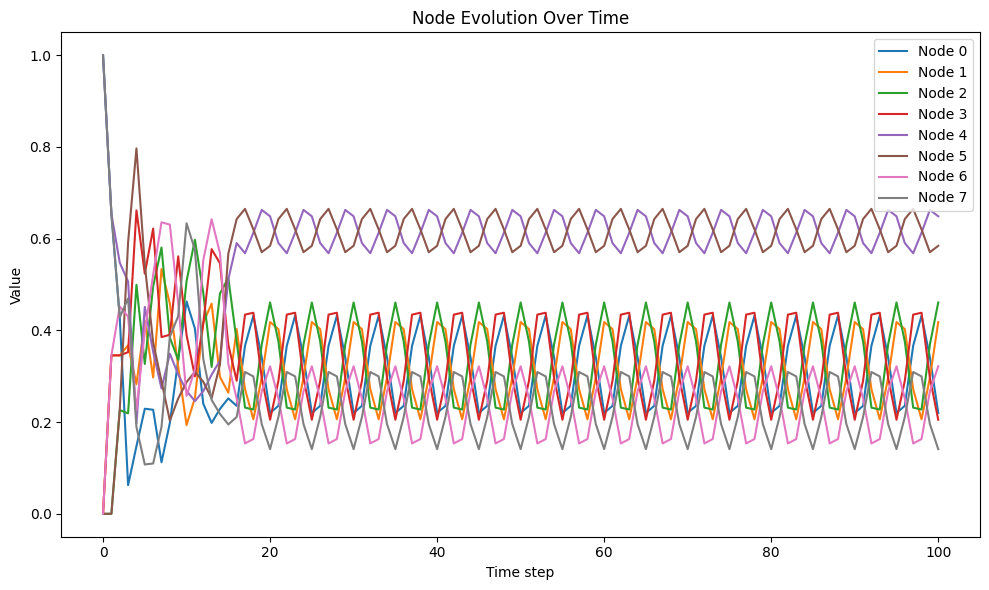

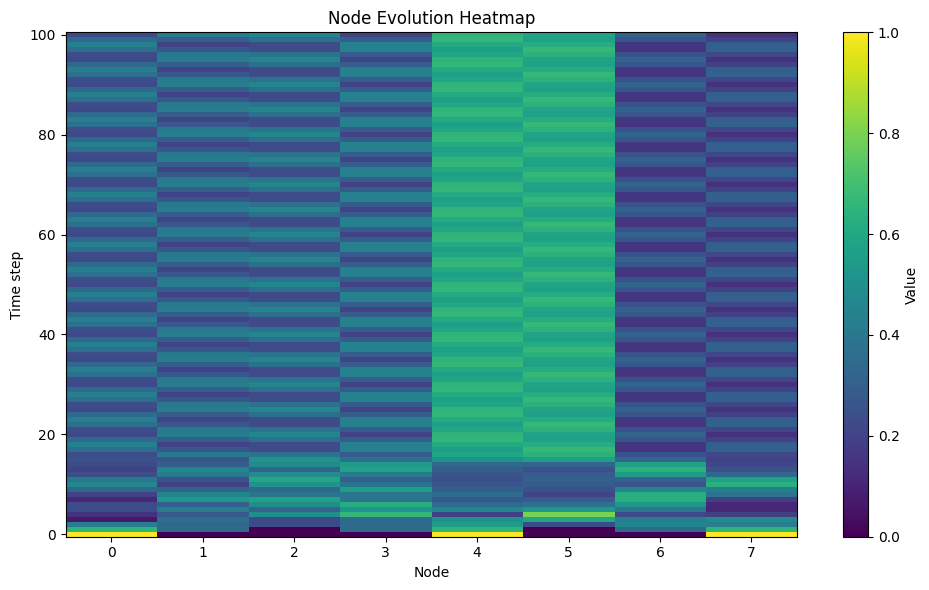

In [25]:
def plot_node_evolution(data):
    data = np.asarray(data)
    time_steps, num_nodes = data.shape

    # Line plot: evolution of each node
    plt.figure(figsize=(10, 6))
    for i in range(num_nodes):
        plt.plot(range(time_steps), data[:, i], label=f'Node {i}')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title('Node Evolution Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Heatmap: time vs node
    plt.figure(figsize=(10, 6))
    plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Value')
    plt.xlabel('Node')
    plt.ylabel('Time step')
    plt.title('Node Evolution Heatmap')
    plt.tight_layout()
    plt.show()

# Usage:
plot_node_evolution(pops_greedy_c2[0])